In [1]:
import logging
import numpy as np
import pandas as pd
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline

In [2]:
import pandas as pd
from iSDM.species import GBIFSpecies
import rasterio
from rasterio.transform import Affine

In [3]:
# download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCOFNiUHYwcVFVODQ
# Representative example with multiple polygons in the shapefile, and a lot of point-records (also outside rangemaps)
from iSDM.species import IUCNSpecies
salmo_trutta = IUCNSpecies(name_species='Salmo trutta')
salmo_trutta.load_shapefile("../data/fish/selection/salmo_trutta")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/salmo_trutta
The shapefile contains data on 3 species areas.


In [4]:
salmo_trutta.data_full.crs

{'init': 'epsg:4326'}

In [5]:
rasterized = salmo_trutta.rasterize(raster_file="./salmo_trutta_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./salmo_trutta_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


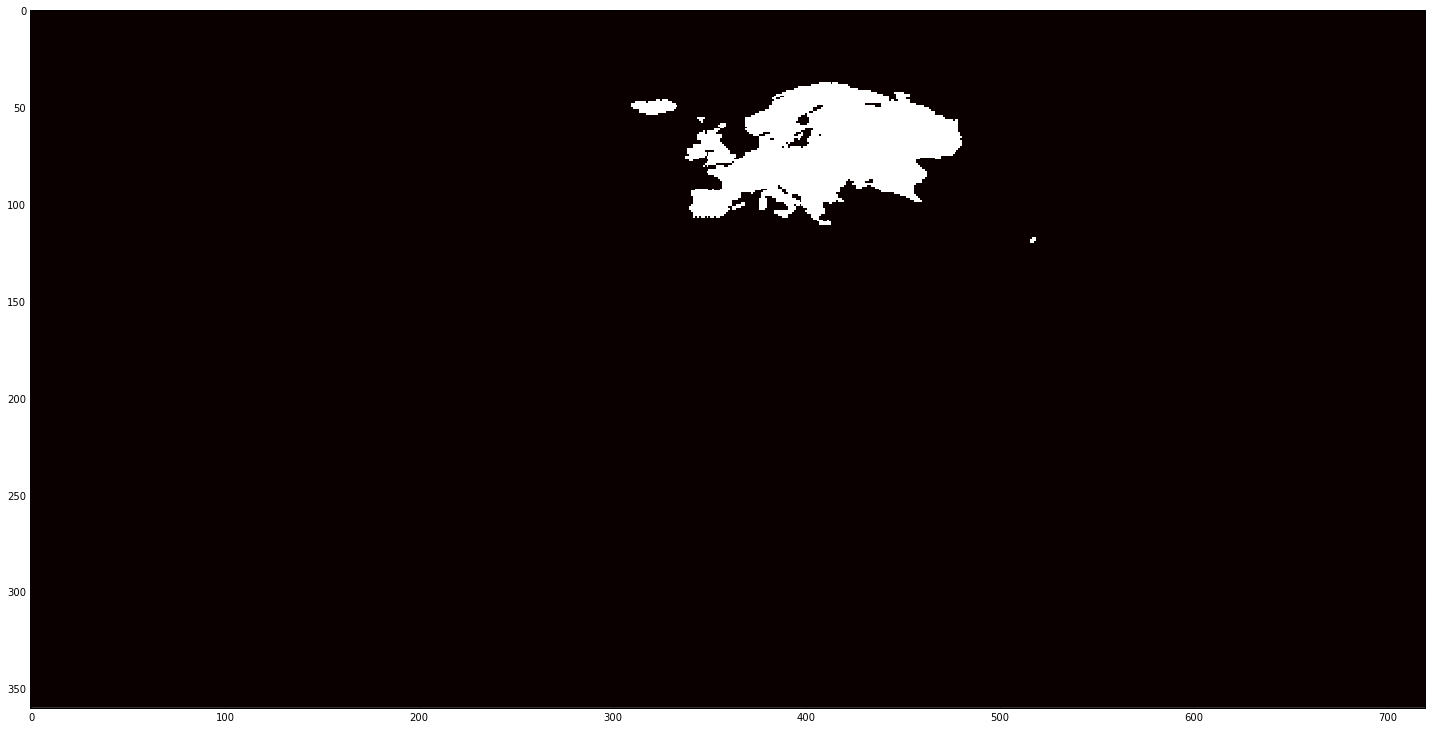

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(rasterized, cmap="hot", interpolation="none")

In [7]:
coordinates = salmo_trutta.pixel_to_world_coordinates() # coordinates of the middle-of-pixels for this species

No raster data provided, attempting to load default...
Loaded raster data from ./salmo_trutta_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./salmo_trutta_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [9]:
from iSDM.environment import RasterEnvironmentalLayer
%matplotlib inline
biomes_adf = RasterEnvironmentalLayer(file_path="/home/daniela/git/iSDM/data/rebioms/w001001.adf", name_layer="Biomes")

In [10]:
raster_biomes_reader = biomes_adf.load_data()

Loaded raster data from /home/daniela/git/iSDM/data/rebioms/w001001.adf 
Driver name: AIG 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'AIG',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 255.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.


In [11]:
raster_data_biomes = raster_biomes_reader.read(1)

In [12]:
np.unique(raster_data_biomes[raster_data_biomes!=raster_biomes_reader.nodata]) # what are the unique values here, ignoring nodata=255

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=uint8)

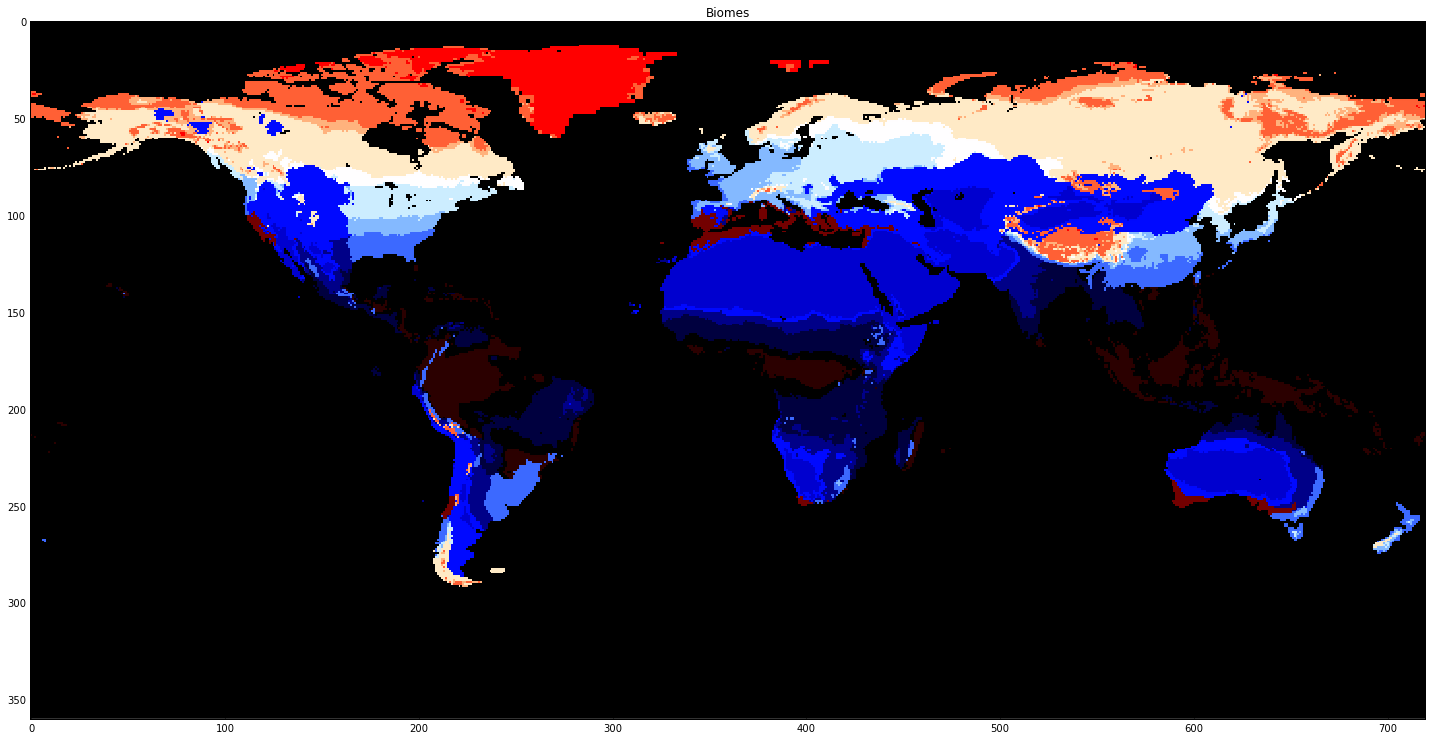

In [13]:
biomes_adf.plot(band_number=1)

In [16]:
raster_data_biomes[raster_data_biomes==255] = 0

In [17]:
selected_biomes = raster_data_biomes * rasterized # as easy as that, to get all overlapping pixels

In [18]:
selected_biomes.shape

(360, 720)

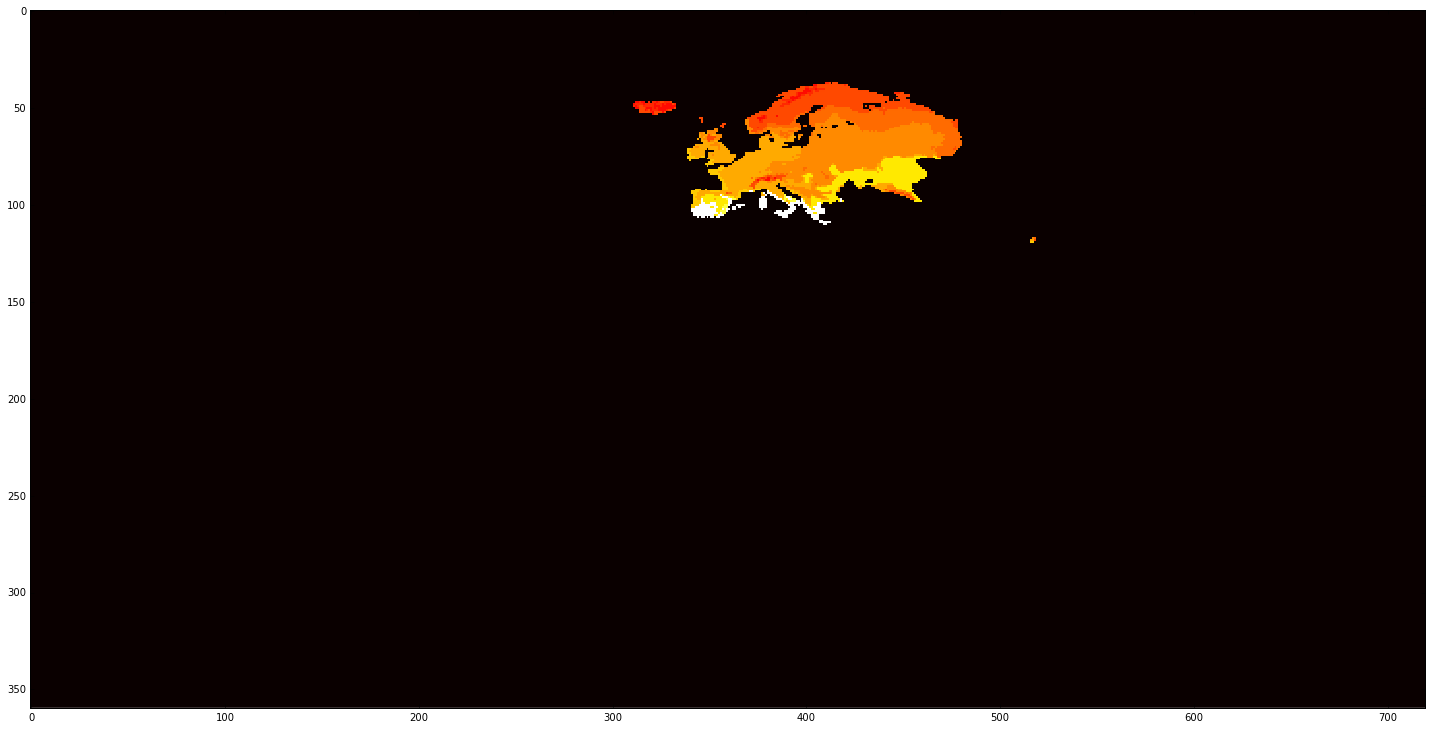

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(selected_biomes, cmap="hot", interpolation="none") # pure awesomeness

In [63]:
 # 13 has overlap with this fish, let's filter-out everything else
#raster_data_biomes[raster_data_biomes!=13] = 0
raster_data_filtered = raster_data_biomes.copy()
raster_data_filtered[raster_data_filtered!=13] = 0

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Data geometrized: converted into GeoPandas dataframe.
Points with NaN coordinates ignored. 


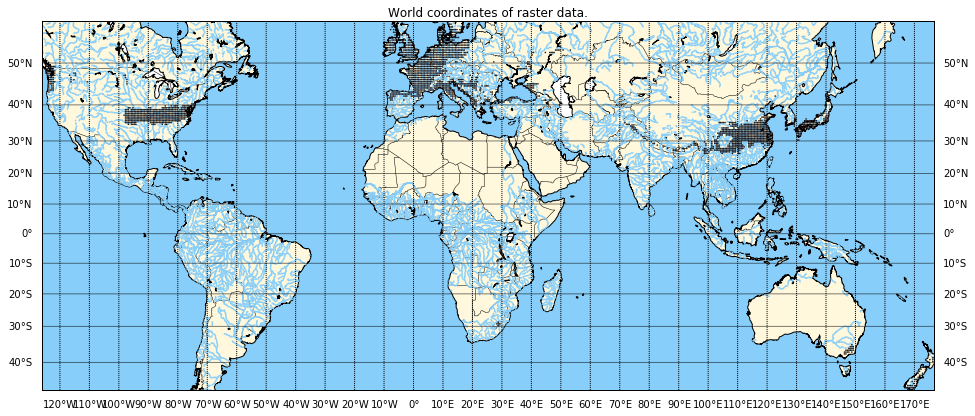

In [64]:
biomes_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=raster_data_filtered)
biomes_adf.plot_world_coordinates(biomes_coordinates)

In [65]:
np.unique(selected_biomes) # these are all the regions that need to be taken into account

array([ 0,  8,  9, 10, 11, 12, 13, 14, 15, 17, 21], dtype=uint8)

In [66]:
# conclusion: world coordinates not even needed at this stage
unique_biomes = np.unique(selected_biomes) # these are all the regions that need to be taken into account
unique_biomes = unique_biomes[1:] # remove the 0

In [67]:
layers = []
for biome in unique_biomes:
    layers.append(np.where(raster_data_biomes==biome ))

In [68]:
layers[2] # coordinates

(array([ 28,  29,  30, ..., 290, 290, 291]),
 array([587, 586, 578, ..., 226, 227, 221]))

In [69]:
raster_data_biomes[layers[2]] # values

array([10, 10, 10, ..., 10, 10, 10], dtype=uint8)

In [70]:
raster_data_biomes[layers[3]] # cool

array([11, 11, 11, ..., 11, 11, 11], dtype=uint8)

In [71]:
empty_raster = np.zeros_like(raster_data_biomes)

In [72]:
# pick out only those layers that have been selected
for layer in layers:
    empty_raster[layer] = raster_data_biomes[layer]

In [73]:
np.unique(empty_raster) # COOL!

array([ 0,  8,  9, 10, 11, 12, 13, 14, 15, 17, 21], dtype=uint8)

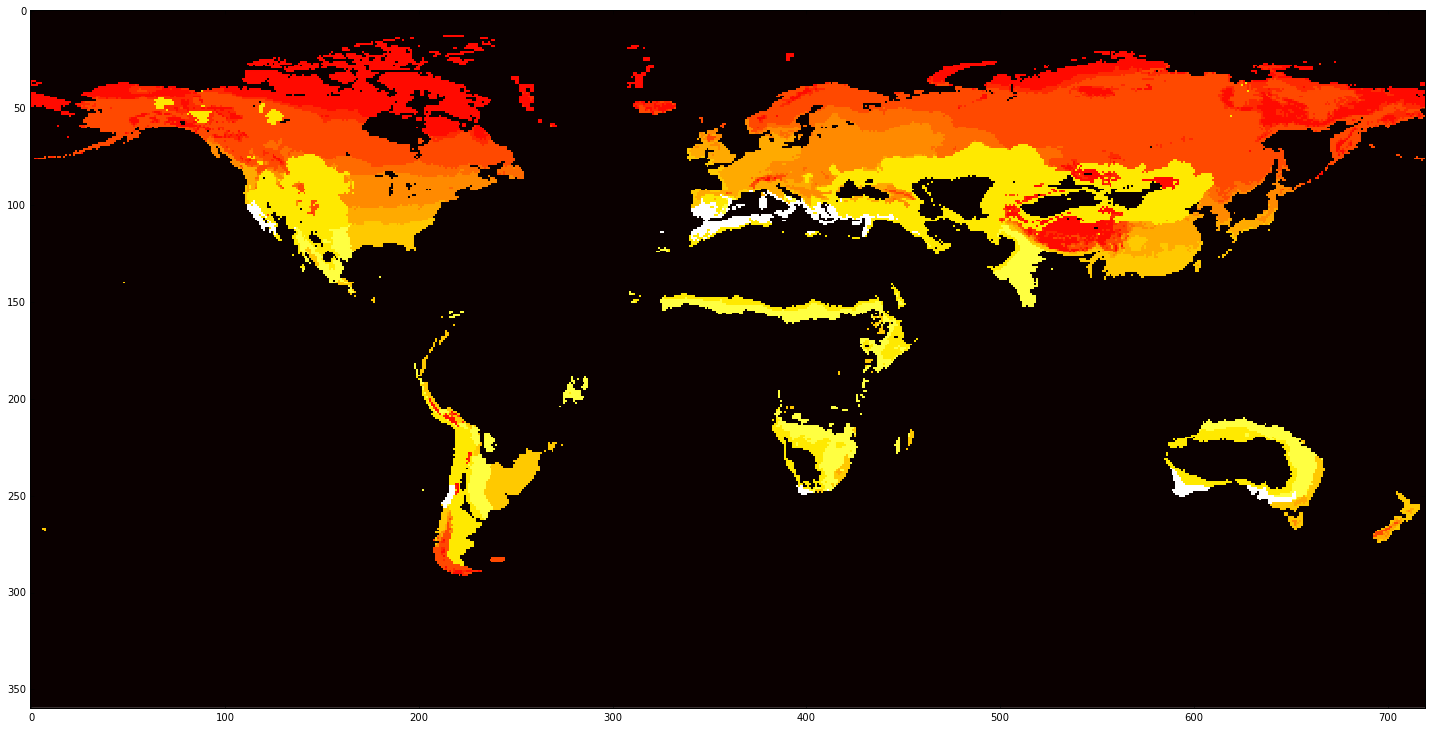

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(empty_raster, cmap="hot", interpolation="none") # pure awesomeness

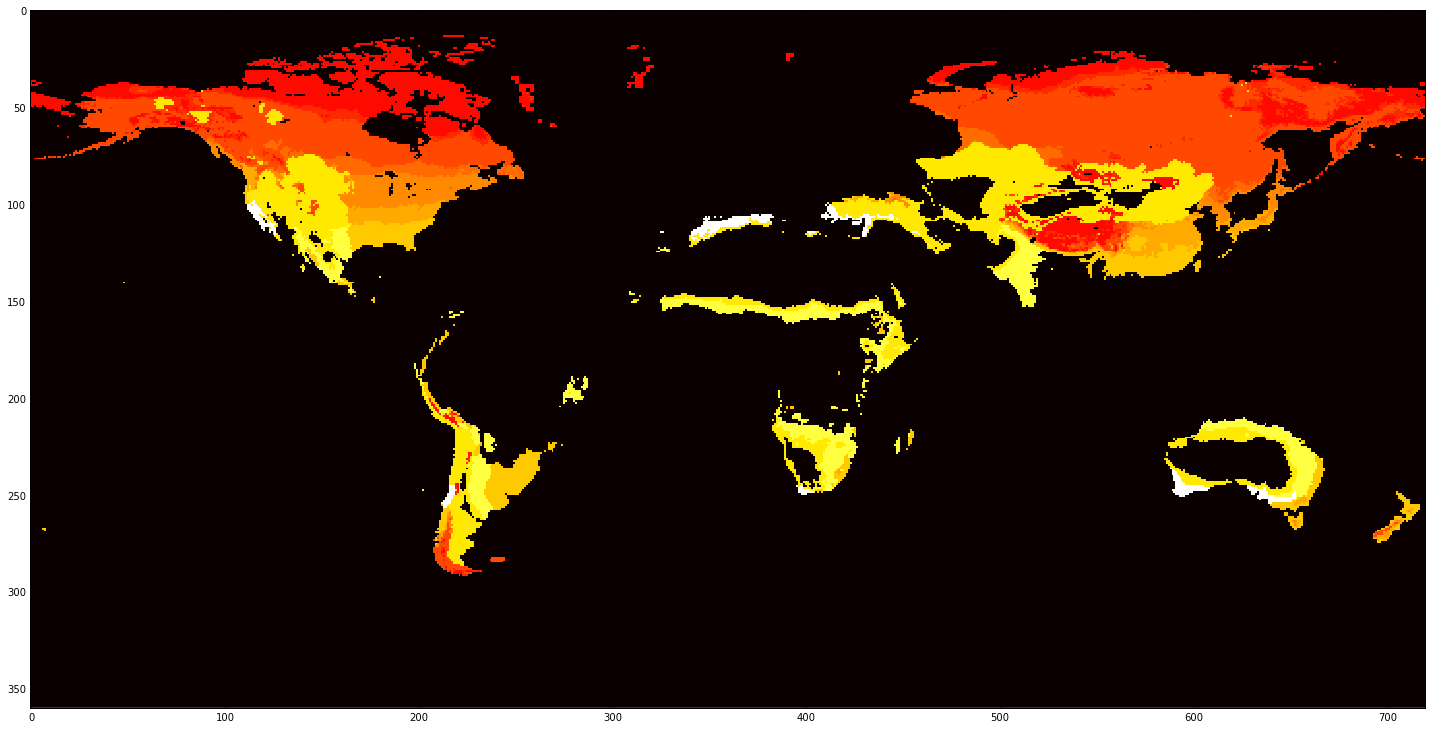

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(empty_raster-selected_biomes, cmap="hot", interpolation="none") # this is where we sample pseudo-absences from!!

In [84]:
final_frame = pd.DataFrame([coordinates[0], coordinates[1]]).T

In [85]:
final_frame.columns=['decimallatitude', 'decimallongitude']

In [95]:
salmo_trutta.data_full.binomial.unique()

array(['Salmo trutta'], dtype=object)

In [102]:
final_frame['species'] = salmo_trutta.data_full.binomial.unique()[0]
final_frame['presence'] = 1

In [103]:
final_frame

,decimallatitude,decimallongitude,species,presence
0,71.25,23.75,Salmo trutta,1
1,71.25,24.25,Salmo trutta,1
2,71.25,24.75,Salmo trutta,1
3,71.25,25.25,Salmo trutta,1
4,71.25,25.75,Salmo trutta,1
5,71.25,26.25,Salmo trutta,1
6,71.25,27.25,Salmo trutta,1
7,71.25,27.75,Salmo trutta,1
8,71.25,28.25,Salmo trutta,1
9,70.75,21.75,Salmo trutta,1


In [105]:
pixels_to_sample_from = empty_raster-selected_biomes

In [110]:
pixels_to_sample_from[pixels_to_sample_from>0].shape # this many pixels to sample from

(36793,)

In [118]:
(x,y) = np.where(pixels_to_sample_from>0) # these are x/y positions of pixels to sample from

In [ ]:
# if x.shape[0]<1000 prolem

In [148]:
length_to_sample = x.shape[0]    

In [164]:
length_to_sample

36793

In [149]:
pixels_to_sample_from[x[3],y[3]]

8

In [210]:
sampled_pixels = np.zeros_like(empty_raster)
random_indices = np.random.randint(0, length_to_sample, 1000)

In [211]:
x[random_indices[0]]

48

In [212]:
y[random_indices[0]]

670

In [213]:
for position in random_indices:
    sampled_pixels[x[position]][y[position]]= pixels_to_sample_from[x[position],y[position]]  # or =1

In [214]:
sampled_pixels.nonzero()[0].shape

(989,)

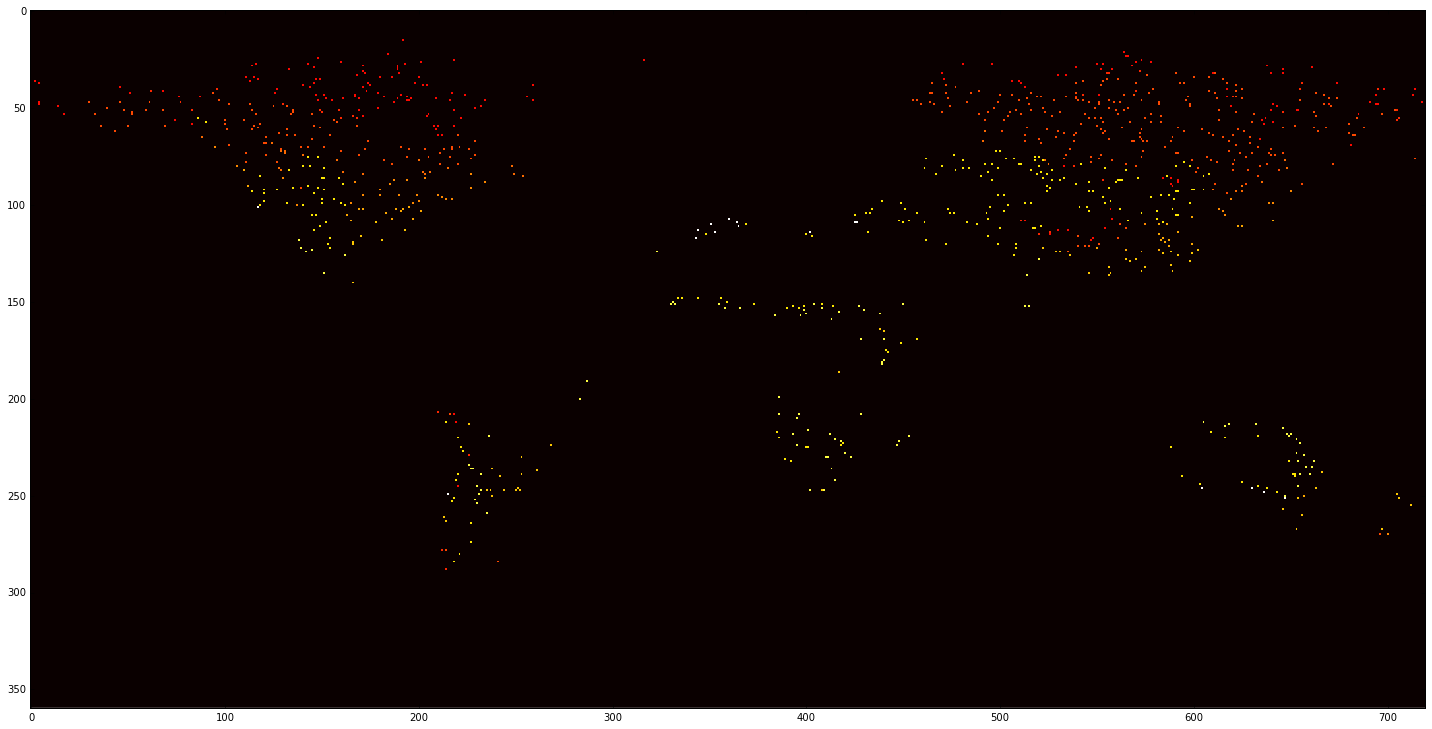

In [215]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,20))
plt.imshow(sampled_pixels, cmap="hot", interpolation="none")

In [220]:
np.product(sampled_pixels.shape)

259200

In [234]:
biomes_adf.pixel_to_world_coordinates(raster_data=sampled_pixels, filter_no_data_value=False)

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Not filtering any no_data pixels.


(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [230]:
empty_df = pd.DataFrame(empty_raster.reshape(np.product(empty_raster.shape),1))

In [235]:
empty_raster_again = np.zeros_like(raster_data_biomes)

In [236]:
emtpy_lat_lon = biomes_adf.pixel_to_world_coordinates(raster_data=empty_raster_again, filter_no_data_value=False)

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Not filtering any no_data pixels.


In [238]:
emtpy_lat_lon[0].shape

(259200,)

In [242]:
final_frame_again = pd.DataFrame([emtpy_lat_lon[0], emtpy_lat_lon[1]]).T

In [243]:
final_frame_again

,0,1
0,89.75,-179.75
1,89.75,-179.25
2,89.75,-178.75
3,89.75,-178.25
4,89.75,-177.75
5,89.75,-177.25
6,89.75,-176.75
7,89.75,-176.25
8,89.75,-175.75
9,89.75,-175.25


In [245]:
final_frame_again.columns=['decimallatitude', 'decimallongitude']

In [265]:
final_frame_again.head()

,decimallatitude,decimallongitude
0,89.75,-179.75
1,89.75,-179.25
2,89.75,-178.75
3,89.75,-178.25
4,89.75,-177.75


In [249]:
sampled_pseudo_absences = biomes_adf.pixel_to_world_coordinates(raster_data=sampled_pixels)

Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [263]:
sampled_pseudo_absences_pd = pd.DataFrame([sampled_pseudo_absences[0], sampled_pseudo_absences[1]]).T

In [266]:
sampled_pseudo_absences_pd.columns=['decimallatitude', 'decimallongitude']

In [268]:
sampled_pseudo_absences_pd.head()

,decimallatitude,decimallongitude
0,82.25,-83.75
1,79.25,102.25
2,78.75,-87.75
3,78.25,102.75
4,78.25,103.25


In [270]:
sampled_pseudo_absences_pd.shape

(989, 2)

In [271]:
sampled_pseudo_absences_pd['Species 1'] = 0

In [272]:
sampled_pseudo_absences_pd.head()

,decimallatitude,decimallongitude,Species 1
0,82.25,-83.75,0
1,79.25,102.25,0
2,78.75,-87.75,0
3,78.25,102.75,0
4,78.25,103.25,0


In [277]:
merged_with_pseudo_absences = pd.merge(final_frame_again, sampled_pseudo_absences_pd, on=["decimallatitude", "decimallongitude"], how="outer")

In [286]:
merged_with_pseudo_absences[merged_with_pseudo_absences['Species 1']==0].head()

,decimallatitude,decimallongitude,Species 1
10992,82.25,-83.75,0.0
15684,79.25,102.25,0.0
16024,78.75,-87.75,0.0
17125,78.25,102.75,0.0
17126,78.25,103.25,0.0


In [284]:
final_presences = pd.DataFrame([coordinates[0], coordinates[1]]).T

In [287]:
final_presences.columns=['decimallatitude', 'decimallongitude']

In [291]:
final_presences['Species 1'] = 1

In [305]:
merged_with_pseudo_absences_and_presences = pd.merge(merged_with_pseudo_absences, final_presences, on=["decimallatitude", "decimallongitude", "Species 1"], how="outer")

In [306]:
merged_with_pseudo_absences_and_presences.head()

,decimallatitude,decimallongitude,Species 1
0,89.75,-179.75,NaN
1,89.75,-179.25,NaN
2,89.75,-178.75,NaN
3,89.75,-178.25,NaN
4,89.75,-177.75,NaN
